# 2-6 사이킷런으로 수행하는 타이타닉 생존자 예측

- titanic_train.csv 불러오기

In [63]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['dark_background'])

%matplotlib inline

titanic_df = pd.read_csv('C:/ML_Study/data_set/titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- padas .info() 함수 이용하여, 학습 데이터 정보 살펴보기.
<br>
RangeIndex : DataFrame의 인덱스의 범위를 나타내므로 전체 로우 수를 알 수 있다. ( 전체 데이터의 수 확인 O )
<br>
Date Columns : 12개 (float64타입 2게, int64타입 5개, *object타입 5개) 
<br>*object타입은 string타입임. 


In [13]:
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


- 결측치(NaN) 확인하기 -> .isnull().sum()
<br> Age, Cabin, Embarked 열 데이터 내에 NaN 존재함.

In [14]:
titanic_df.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- 사이킷런 머신러닝 알고리즘은 NaN값 허용 X -> fillna() 이용하여 NaN값 처리하기.

In [15]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum()) # 모든 칼럼의 Null 값이 있는지 없는지 다시 확인.

데이터 세트 Null 값 개수  0


- 문자열 피처(범주형), Sex, Cabin, Embarked 피처들의 값 분류 확인 

In [16]:
print('#Sex 값 분포 : \n', titanic_df['Sex'].value_counts())
print(' \n#Cabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print(' \n#Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

#Sex 값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64
 
#Cabin 값 분포 :
 N              687
C23 C25 C27      4
B96 B98          4
G6               4
D                3
              ... 
B30              1
B50              1
B69              1
D30              1
A6               1
Name: Cabin, Length: 148, dtype: int64
 
#Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [17]:
# Cabin(선실) 피처의 속성값이 제대로 정리가 되지 않음.
# 예를 들어 'C23 C25 C27'과 같이 여러 Cabin이 한꺼번에 표기된 Cabin값의 데이터 4건 존재.
# 선실 등급을 나타내는 첫 번째 알파벳이 중요함 -> 이 시절에는 일등실과 삼등실의 차이가 더 극명하게 존재했을 것이기 때문에.(주관적인 견해라기 보다는 1912년 시대 배경을 따져보면 그러하다))
# Cabin 속성의 경우 앞 문자만 추출해보자,

titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


## 결과 예측을 위한 데이터 탐색 시작
- 각 승객의 생존 확률 <br> 영화 '타이타닉'에서 나왔듯이 바다에서 사고가 날 경우, 여성과 아이들 그리고 노약자가 첫번째 구조 대상일 것이다(Women and Children First). 그 다음은 아마도 부자나 유명인. 안타깝게도 삼등실에 탄 많은 가난한 이는 타이타닉 호에서 운명을 맞았을 것. <br> -> 성별이 생존확률에 어떤 영향을 미쳤는지, 성별에 따른 생존자 수를 비교해보자.



- 성별이 생존확률에 어떤 영향을 미쳤는지, 성별에 따른 생존자 수를 비교해보자.

In [18]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

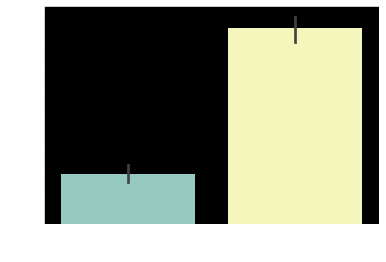

In [19]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

- 부유함이 생존확률에 어떤 영향을 미쳤는지, 객실등급에 다른 생존자 수를 비교해보자.

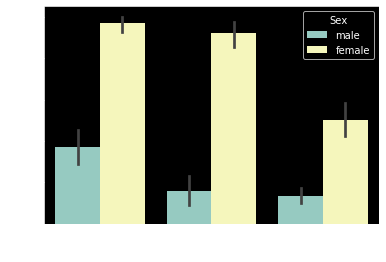

In [22]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

- 나이가 생존확률에 어떤 영향을 미쳤는지, 연령(범위)에 딸든 생존자 수를 비교해보자
<br> Baby : 0 ~ 5세, Child : 6 ~ 12세, Teenager : 13 ~ 18세, Student : 19  ~ 25세, Young Adult : 26 ~ 35세, Adult : 36 ~ 60세, Elderly : 61세 이상

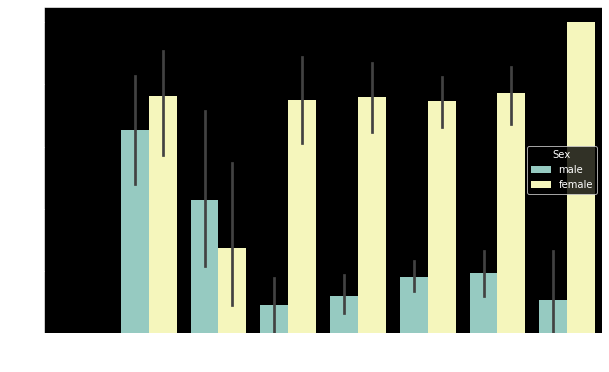

In [23]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 사용.
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age<= 5: cat = 'Baby'
    elif age<= 12: cat = 'Child'
    elif age<= 18: cat = 'Teenager'
    elif age<= 25: cat = 'Student'
    elif age<= 35: cat = 'Young Adult'
    elif age<= 60: cat = 'Adult'
    else : cat = 'Elderly'
        
    return cat

# 막대그래프의 크기 figure을 더 크게 설정
plt.figure(figsize=(10,6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child','Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정.
# get_category(X)는 입력값으로 'Age'칼럼 값을 받아서 해당하는 cat반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

## 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환 : 인코딩

In [26]:
from sklearn import preprocessing 

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df=encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


## 데이터 전처리 함수 생성 
- 지금까지 피처를 가공한 내역을 정리하고 이를 함수로 만들어 쉽게 재사용할 수 있도록 만들어보자. 데이터의 전처리를 전체적으로 호출하는 함수는 transform_features() 이며 Null처리, 포매팅, 인코딩을 수행하는 내부 함수로 구성했다.

In [38]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df
    
# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])        
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [28]:
# 데이터 전처리를 수행하는 transform_features() 함수를 만들었으니 이 함수를 이용해 다시 원본 데이터를 가공해 보자.
# 원본 CSV 파일을 다시 로딩하고 타이타닉 생존자 데이터 세트의 레이블인 Survived 속성만 별도 분리해 클래스 결정값 데이터 세트로 만들어보자. 그리고 Survived 속성을 드롭해 피터 데이터 세트를 만들자.
# 이렇게 생성된 피처 데이터 세트에 transform_features()를 적용해 데이터를 가공합니다.

In [39]:
# 원본 데이터를 재로딩 후, 피처 데이터 세트와 레이블 데이터 세트 추출.
titanic_df = pd.read_csv('C:/ML_Study/data_set/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

- X_titanic_df 데이터프레임을 train_test_split() API를 이용하여 별도의 테스트 데이터 세트를 추출.
<br> 테스트 데이터 세트는 전체 데이터의 20%

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

## 생존자 예측해보기
- ML 알고리즘인 결정트리, 랜덤 포레스트, 로지스틱 회귀를 이용하여 타이타닉 생존자를 예측해보자.
- 위의 알고리즘에 대한 상세한 수학적 개념 설명은 앞으로 다룰 예정이다.
- 이번 2-6챕터에서는 사이킷런 기반의 머신러닝 알고리즘 클래스에 익숙해지는 데 집중해보자.
<br> 결정트리 - DecisionTreeClassifier 
<br> 랜덤포레스트 - RandomForestClassifier
<br> 로지스틱 회귀 - LogisticRegreesion
- 이들 사이킷런 클래스를 이용해 train_test_split()으로 분리한 학습 데이터와 테스트 데이터를 기반으로 머신러닝 모델을 학습(fit)하고 예측(predict)해보자. 예측 성능 평가는 '정확도'를 기반으로 진행할 것이다. 이를 위해 accuracy_score() API를 이용할 것이다. 
- DecisionTreeClassifier과 RandomForestClassifier에 생성 인자로 입력된 random_state=11은 예제를 수행할 때마다 같은 결과를 출력하기 위한 용도일 뿐. 실제 사례에서는 제거할 것임.

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도: 0.8324
RandomForestClassifier 정확도: 0.8659


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


- 교차검증으로 결정 트리 모델을 좀 더 평가해보자.
- 사이킷런 model_selection 패키지의 KFold 클래스, cross_val_score(), GridSearchCV 클래스 모두 사용

In [52]:
# 1. KFold클래스를 이용하여 교차검증 수행. 폴드 개수는 5개
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측 결과 저장을 위한 리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행.
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        #Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train,y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
        
    #5개 fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))
    
#exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차검증 0 정확도: 0.7542
교차검증 1 정확도: 0.7809
교차검증 2 정확도: 0.7865
교차검증 3 정확도: 0.7697
교차검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [54]:
# 2. cross_val_score() API를 이용하여 교차검증 수행
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7765
교차 검증 2 정확도: 0.7809
교차 검증 3 정확도: 0.7753
교차 검증 4 정확도: 0.8418
평균 정확도: 0.7835


In [56]:
# 3.GridSearchCV를 이용하여 DecisionTreeClassifier의 최적 파라미터를 찾고 예측 성능을 측정해 보자.
# cv는 5게의 폴드 세트를 지정하고 하이퍼 파라미터는 max_depth, min_samples_split, min_sample_leaf를 변경하면서 성능을 측정합니다. 
# 최적 파라미터와 그때의 예측을 출력하고, 최적 하이퍼 파라미터로 학습된 Estimator을 이용해 위의 train_test_split()으로 분리된 테스트 데이터 세트에 예측을 수행해 예측 정확도를 출력해보자.
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5],
             'min_samples_leaf':[1,5,8]}
grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy',cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

#GridSSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행.
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [57]:
# -> 최적화된 하이퍼 파라미터인 max_depth 3, min_samples_leaf 1, min_samples_split 2로 DecisionTreeClassifier을 학습시킨 뒤, 
# 예측 정확도가 8% 이상 증가하여 약 87.15%로 향상되었다. 일반적으로 하이퍼 파라미터를 튜닝하더라도 이 정도 수준으로 증가하기는 매우 어렵다. 테스트용 데이터 세트가 작기 때문에 수치상으로 예측 성능이 많이 증가한 것처럼 보인 것이다.

# 2-7 정리.

- 머신러닝 애플리케이션은 데이터의 가공 및 변환 과정의 전처리 작업, 데이터를 학습 데이터와 테스트 데이터로 분리하는 데이터 세트 분리 작업을 거친 후에 학습 데이터를 기반으로 머신러닝 알고리즘을 적용해 학습시킵니다. 
그리고 학습된 모델을 기반으로 테스트 데이터에 대한 예측을 수행하고, 이렇게 예측된 결괏값을 실제 결과값과 비교해 머신러닝 모델에 대한 평가를 수행하는 방식으로 구성됩니다. 
- 데이터 전처리 작업은 오류 데이터의 보정이나 결손값(NaN) 처리 등의 다양한 데이터 클렌징 작업, 레이블 인코딩이나 원-핫 인코딩과 같은 인코딩 작업, 그리고 데이터의 스케일링/정규화 작업 등으로 머신러닝 알고리즘이 최적으로 수행될 수 있게 데이터를 사전 처리하는 것입니다.
- 머신러닝 모델은 학습 데이터 세트로 학습한 뒤 반드시 별도의 테스트 데이터 세트로 평가되어야 합니다. 또한 테스트 데이터의 건수 부족이나 고정된 테스트 데이터 세트를 이용한 반복적인 모델의 학습과 평가는 해당 테스트 데이터 세트에만 치우친 빈약한 머신러닝 모델을 만들 가능성이 높습니다. 이를 해결하기 위해 학습 데이터 세트를 학습 데이터와 검증 데이터로 구성된 여러 개의 폴드 세트로 분리해 교차 검증을 수행할 수 있습니다. 사이킷런은 이런한 교차 검증을 지원하기 위해 KFold, StratifiedKFold, cross_val_score()등의 다양한 클래스와 함수를 제공합니다. 또한 머신러닝 모델의 최적의 하이퍼 파라미터를 교차검증을 통해 추출하기 위해 GridSearchCV를 제공합니다. 
- 사이킷런은 머신러닝 프로세스의 모든 단계에서 적용될 수 있는 많은 API와 직관적인 개발 프레임워크를 제공하면서, 그동안 많은 데이터 분석가/과학자들에게 애용되어 왔으며, 많은 기업들이 이를 기반으로 기업용 머신러닝 애플리케이션을 작성해 왔습니다. 결국 사이킷런은 다양한 개발 환경에서 오랜 기간동안 라이브러리의 안정성과 유용성이 검증된 패키지이며, 파이썬 기반에서 머신러닝을 배우기를 원한다면 반드시 경험해야할 패키지라고 생각합니다. 